#Training UNet for Brain Tumor Segmentation

##1. Loading Dataset

In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=61259d3943272bd9d5063d028e276434d30b6be5503f02f487b78d575af244e1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="-")
project = rf.workspace("-").project("brain-tumor-yzzav")
dataset = project.version(1).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to BRAIN-TUMOR-1 in coco-segmentation:: 100%|██████████| 842/842 [00:00<00:00, 1839.71it/s]


In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from pycocotools.coco import COCO

## Setting TRAIN/VAL Paths

In [ ]:
extract_folder = '/content/BRAIN-TUMOR-1'

In [ ]:
# Setting up paths and configurations for the brain tumor dataset

# Paths
TRAIN_IMAGE_PATH = os.path.join(extract_folder, "train")
TRAIN_ANOT_PATH = os.path.join(TRAIN_IMAGE_PATH, "_annotations.coco.json")
TRAIN_MASK_PATH = os.path.join(TRAIN_IMAGE_PATH, "masks")

VAL_IMAGE_PATH = os.path.join(extract_folder, "valid")
VAL_ANOT_PATH = os.path.join(VAL_IMAGE_PATH, "_annotations.coco.json")
VAL_MASK_PATH = os.path.join(VAL_IMAGE_PATH, "masks")

# Check if mask directories exist, if not, create them
if not os.path.exists(TRAIN_MASK_PATH):
    os.mkdir(TRAIN_MASK_PATH)
if not os.path.exists(VAL_MASK_PATH):
    os.mkdir(VAL_MASK_PATH)

# Configurations
CATEGORY_NAMES = ["tumor"]  # Assuming the category name for brain tumors is 'tumor'
SEED = 42  # For reproducibility
IMAGE_SIZE = (128, 128)  # Size to which images will be resized for training
INPUT_SHAPE = (*IMAGE_SIZE, 3)  # Shape of input to the UNET model
BATCH_SIZE = 8  # Batch size for training

TRAIN_IMAGE_PATH, TRAIN_ANOT_PATH, VAL_IMAGE_PATH, VAL_ANOT_PATH


('/content/BRAIN-TUMOR-1/train',
 '/content/BRAIN-TUMOR-1/train/_annotations.coco.json',
 '/content/BRAIN-TUMOR-1/valid',
 '/content/BRAIN-TUMOR-1/valid/_annotations.coco.json')

In [ ]:
INPUT_SHAPE

(128, 128, 3)

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import os
import cv2

def create_masks(coco, img_ids, cat_ids, mask_dir):
    """
    Create masks from COCO annotations and save them to the specified directory.

    Parameters:
    - coco: COCO object with loaded annotations.
    - img_ids: List of image IDs.
    - cat_ids: List of category IDs.
    - mask_dir: Directory where masks should be saved.
    """
    for img_id in img_ids:
        # Get annotations for the current image
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        # Get image metadata
        img_info = coco.loadImgs(img_id)[0]
        height = img_info['height']
        width = img_info['width']

        # Create an empty mask
        mask = np.zeros((height, width))

        # For each annotation, add it to the mask
        for ann in anns:
            mask += coco.annToMask(ann)

        # Ensure the mask is binary (values in {0, 1})
        mask = np.where(mask > 0, 1, 0).astype(np.uint8)

        # Save the mask to the specified directory
        mask_filename = os.path.join(mask_dir, img_info['file_name'].replace('.jpg', '.png'))
        cv2.imwrite(mask_filename, mask * 255)

# Initialize COCO objects for training and validation data
coco_train = COCO(TRAIN_ANOT_PATH)
coco_val = COCO(VAL_ANOT_PATH)

# Extract image IDs and category IDs for the training and validation sets
cat_ids_train = coco_train.getCatIds(catNms=CATEGORY_NAMES)
img_ids_train = coco_train.getImgIds(catIds=cat_ids_train)

cat_ids_val = coco_val.getCatIds(catNms=CATEGORY_NAMES)
img_ids_val = coco_val.getImgIds(catIds=cat_ids_val)

# Create masks for training and validation data
create_masks(coco_train, img_ids_train, cat_ids_train, TRAIN_MASK_PATH)
create_masks(coco_val, img_ids_val, cat_ids_val, VAL_MASK_PATH)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


#Custom DataGenerator Class

In [ ]:
from tensorflow.keras.utils import Sequence
from skimage.transform import resize
import glob

class DataGen(Sequence):
    def __init__(self, img_folder, mask_folder, image_size, batch_size):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.image_size = image_size
        self.batch_size = batch_size

        self.img_files = glob.glob(os.path.join(img_folder, '*.jpg'))
        self.mask_files = [os.path.join(mask_folder, os.path.basename(img_file).replace('.jpg', '.png'))
                           for img_file in self.img_files]
        self.indexes = np.arange(len(self.img_files))

    def __len__(self):
        return int(np.ceil(len(self.img_files) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size

        batch_img_files = self.img_files[start_idx:end_idx]
        batch_mask_files = self.mask_files[start_idx:end_idx]

        imgs = []
        masks = []

        for img_file, mask_file in zip(batch_img_files, batch_mask_files):
            img = cv2.imread(img_file)
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Warning: Image not loaded: {img_file}")
                continue

            if mask is None:
                print(f"Warning: Mask not loaded: {mask_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = resize(img, self.image_size)
            mask = resize(mask, self.image_size)
            mask = np.expand_dims(mask, axis=-1)

            imgs.append(img)
            masks.append(mask)

        return np.array(imgs), np.array(masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Re-instantiate data generators with checks
train_gen = DataGen(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, IMAGE_SIZE, BATCH_SIZE)
val_gen = DataGen(VAL_IMAGE_PATH, VAL_MASK_PATH, IMAGE_SIZE, BATCH_SIZE)

# Check the first batch to see if images and masks are loaded correctly
sample_images, sample_masks = train_gen[0]
sample_images.shape, sample_masks.shape



((8, 128, 128, 3), (8, 128, 128, 1))

In [ ]:
print(train_gen)

#Defining UNET

In [ ]:
import tensorflow as tf

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.concatenate([us, skip], axis=3)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = tf.keras.layers.Input(INPUT_SHAPE)

    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])

    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model


##Evaluation Metrices

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    union = tf.reduce_sum(y_true, axis=-1) + tf.reduce_sum(y_pred, axis=-1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


In [ ]:
train_gen[5][1].shape

(8, 128, 128, 1)

##Training (50 Epochs)

In [ ]:
# Compile the model
model = UNet()
model.compile(optimizer="adam", loss=bce_dice_loss, metrics=[dice_coef, iou_coef, 'accuracy'])

# Define callbacks and other training configurations
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

epochs = 50
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)


Epoch 1/50
73/73 [==============================] - ETA: 0s - loss: 1.0717 - dice_coef: 0.1772 - iou_coef: 0.8942 - accuracy: 0.9103Warning: Mask not loaded: /content/BRAIN-TUMOR-1/valid/masks/y292_jpg.rf.04df85fe29e15f44429e12c87fb42dbf.png

Epoch 1: val_loss improved from inf to 0.83598, saving model to best_model.h5
73/73 [==============================] - 64s 597ms/step - loss: 1.0717 - dice_coef: 0.1772 - iou_coef: 0.8942 - accuracy: 0.9103 - val_loss: 0.8360 - val_dice_coef: 0.3144 - val_iou_coef: 0.9495 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 2/50
73/73 [==============================] - ETA: 0s - loss: 0.7550 - dice_coef: 0.4272 - iou_coef: 0.9505 - accuracy: 0.9178Warning: Mask not loaded: /content/BRAIN-TUMOR-1/valid/masks/y292_jpg.rf.04df85fe29e15f44429e12c87fb42dbf.png

Epoch 2: val_loss improved from 0.83598 to 0.71698, saving model to best_model.h5
73/73 [==============================] - 45s 622ms/step - loss: 0.7550 - dice_coef: 0.4272 - iou_coef: 0.9505 - accuracy: 0

#Evaluation on TEST

In [ ]:
TEST_IMAGE_PATH = os.path.join(extract_folder, "test")
TEST_ANOT_PATH = os.path.join(TEST_IMAGE_PATH, "_annotations.coco.json")
TEST_MASK_PATH = os.path.join(TEST_IMAGE_PATH, "masks")

# Check if mask directories exist, if not, create them
if not os.path.exists(TEST_MASK_PATH):
    os.mkdir(TEST_MASK_PATH)

In [ ]:
# Initialize COCO objects for training and validation data
coco_test = COCO(TEST_ANOT_PATH)

# Extract image IDs and category IDs for the training and validation sets
cat_ids_test = coco_test.getCatIds(catNms=CATEGORY_NAMES)
img_ids_test = coco_test.getImgIds(catIds=cat_ids_train)

# Create masks for training and validation data
create_masks(coco_test, img_ids_test, cat_ids_test, TEST_MASK_PATH)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Quantitative Evaluation
test_gen = DataGen(TEST_IMAGE_PATH, TEST_MASK_PATH, IMAGE_SIZE, BATCH_SIZE)
test_loss, test_dice_coef, test_iou_coef, test_accuracy = model.evaluate(test_gen, verbose=1)

test_dice_coef, test_iou_coef, test_accuracy


16/16 [==============================] - 8s 486ms/step - loss: 0.1491 - dice_coef: 0.9046 - iou_coef: 0.9934 - accuracy: 0.9665


(0.9046169519424438, 0.9933987855911255, 0.9664578437805176)

##Prediction

1/1 [==============================] - 0s 24ms/step


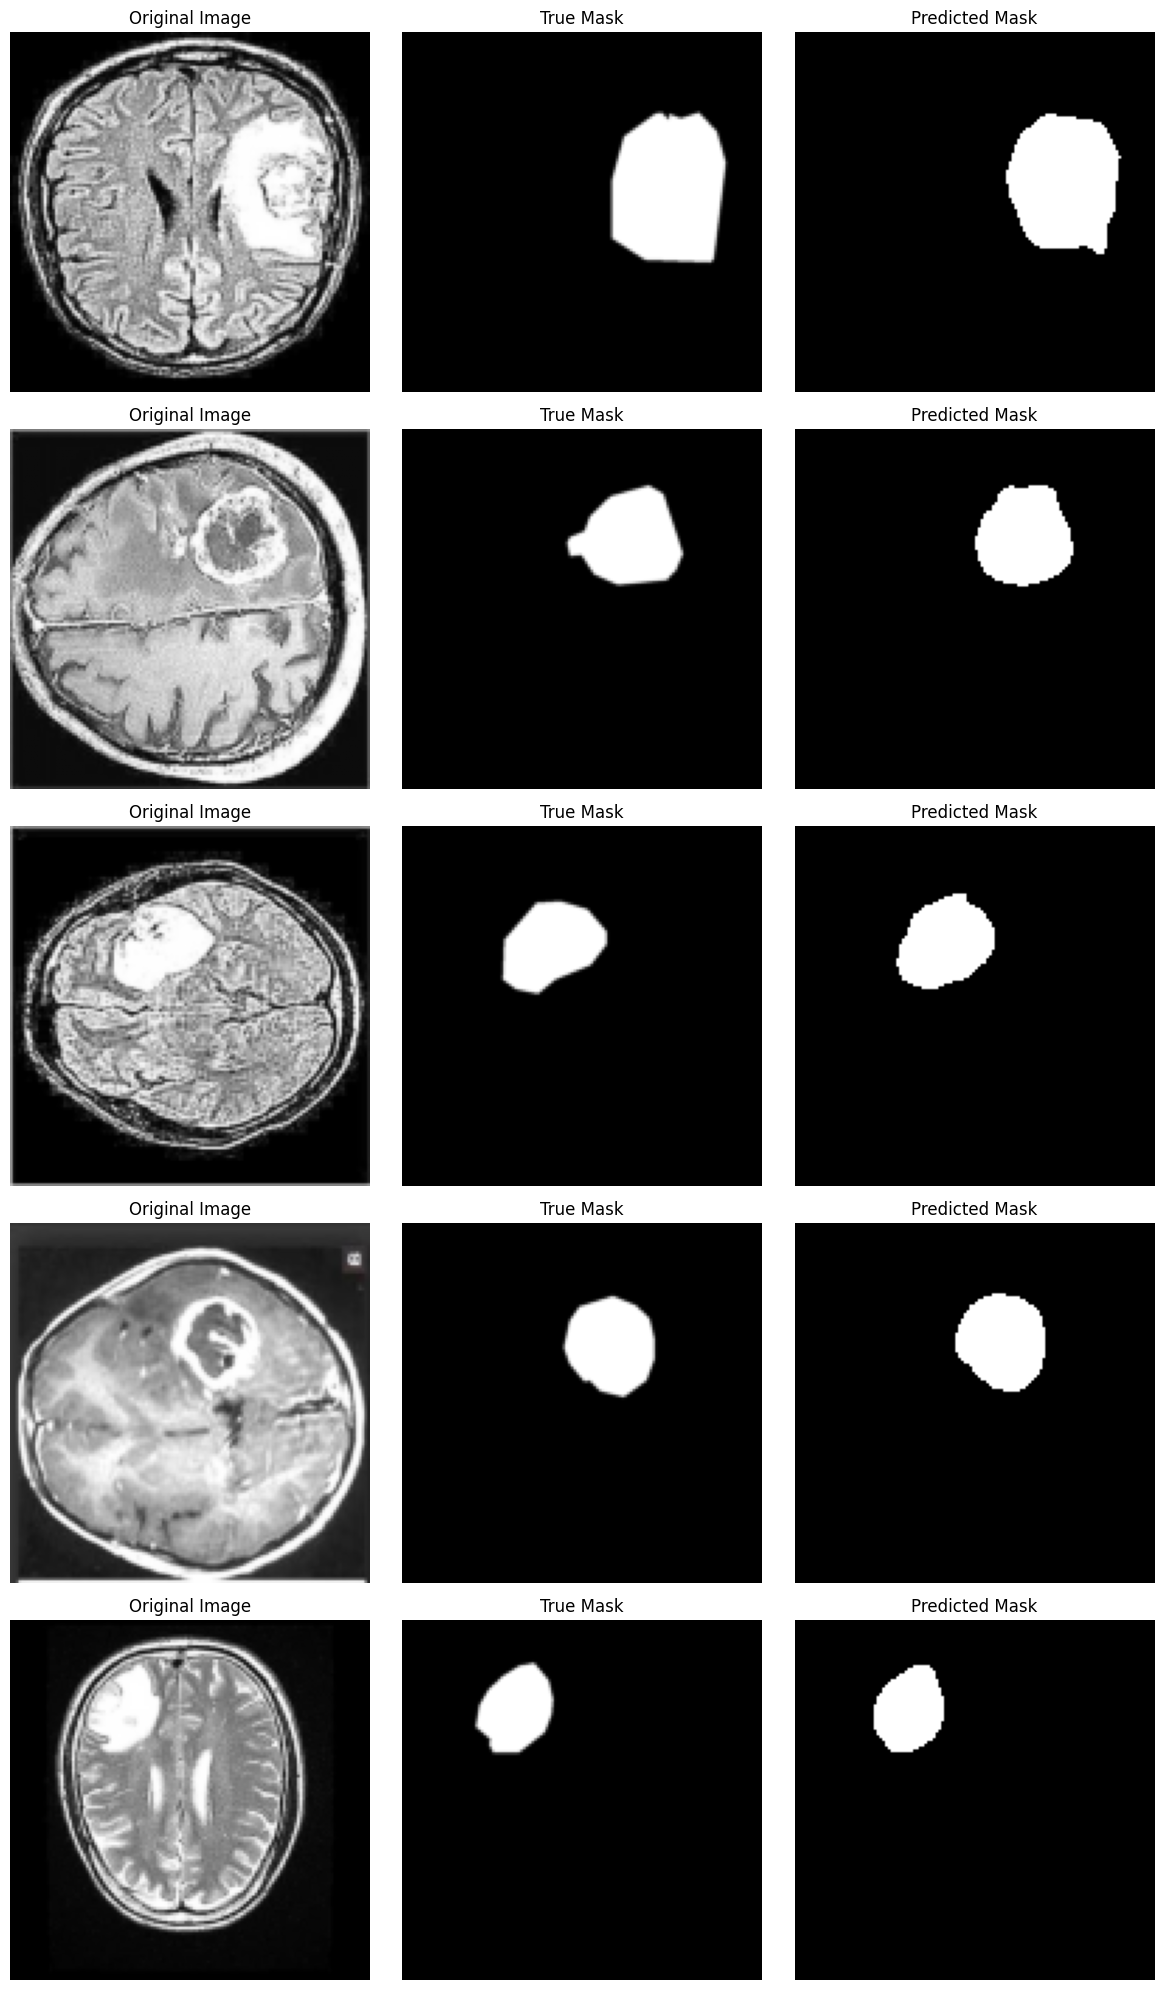

In [ ]:
import matplotlib.pyplot as plt

# Select 5 random images from the test set
random_indices = np.random.choice(len(test_gen), 5)

fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for i, idx in enumerate(random_indices):
    image, true_mask = test_gen[idx]
    pred_mask = model.predict(image)

    # Display original image
    axes[i, 0].imshow(image[0])
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Display true mask
    axes[i, 1].imshow(np.squeeze(true_mask[0]), cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    # Display predicted mask
    axes[i, 2].imshow(np.squeeze(pred_mask[0] > 0.5), cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


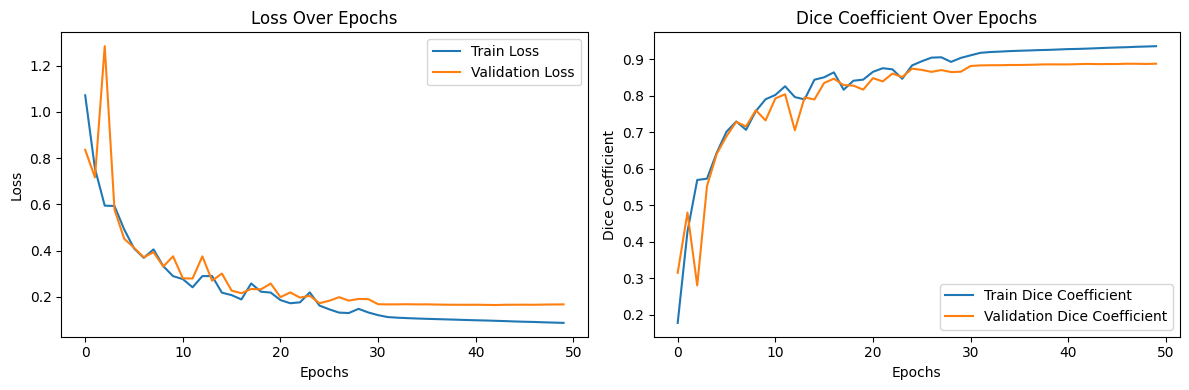

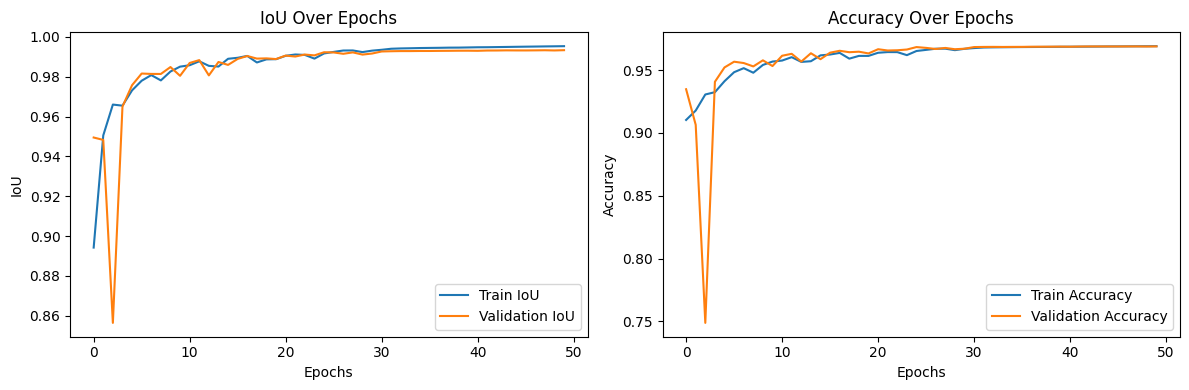

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Dice Coefficient
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.tight_layout()
plt.show()

# Plot IoU
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_coef'], label='Train IoU')
plt.plot(history.history['val_iou_coef'], label='Validation IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
